import

In [508]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import statistics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

function

In [509]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP

In [510]:
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity

In [511]:
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity

In [512]:
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy

In [513]:
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision

In [514]:
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1

parameter1 split1

In [515]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


In [516]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [517]:
# create the individual models
model = LogisticRegression(C=51.79474679231202, max_iter=3000, penalty='l2', solver='sag')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

split1
############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 3 36]] 

----------------
Sensitivity: 92.31%
Specificity: 98.08%
Accuracy: 95.60%
Precision: 97.30%
Sensitivity: 92.31%
Precision: 97.30%
F1: 94.74%


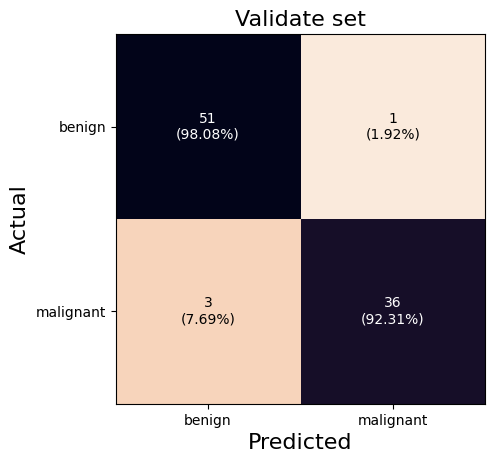

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 97.83%
Accuracy: 95.61%
Precision: 98.46%
Sensitivity: 94.12%
Precision: 98.46%
F1: 96.24%


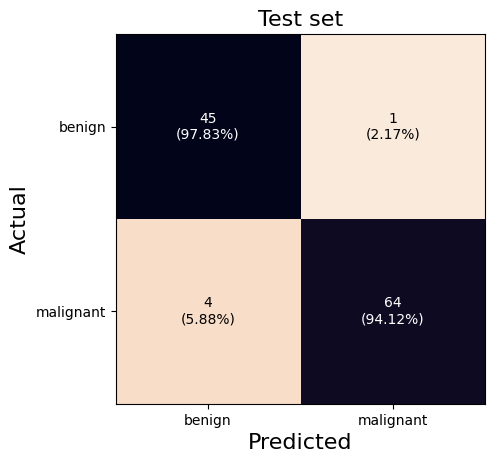

---------------------------------------
AUC validate: 0.9519
AUC test: 0.9597


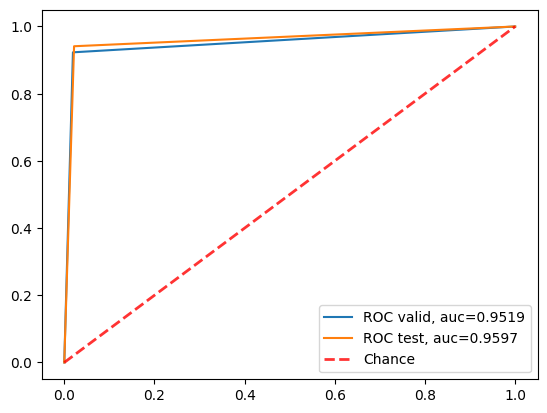

In [518]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split1 = sensitivity(cm_val)
spec_val_split1 = specificity(cm_val)
acc_val_split1 = accuracy(cm_val)
pre_val_split1 = precision(cm_val)
f1_val_split1 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split1 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split1)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [519]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


c:\Users\net\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


split2
############## validate set ################
Confusion Matrix
----------------
[[50  3]
 [ 2 36]] 

----------------
Sensitivity: 94.74%
Specificity: 94.34%
Accuracy: 94.51%
Precision: 92.31%
Sensitivity: 94.74%
Precision: 92.31%
F1: 93.51%


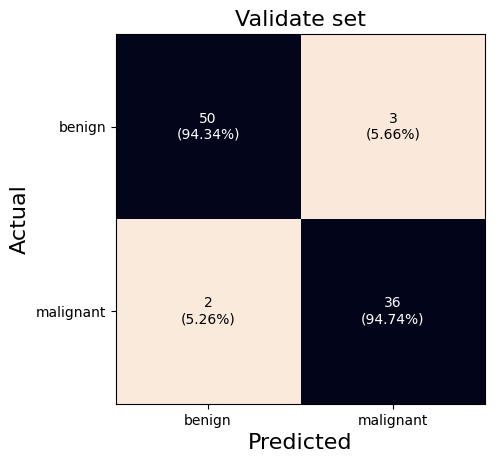

################# test set ##################
Confusion Matrix
----------------
[[43  3]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 93.48%
Accuracy: 94.74%
Precision: 95.59%
Sensitivity: 95.59%
Precision: 95.59%
F1: 95.59%


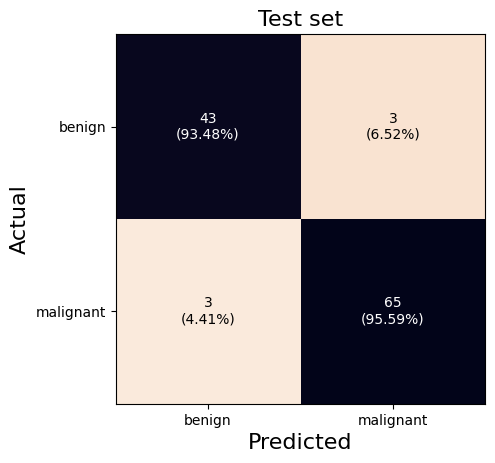

---------------------------------------
AUC validate: 0.9454
AUC test: 0.9453


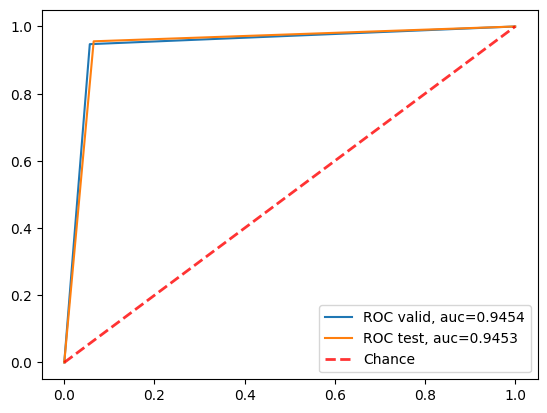

In [520]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split2 = sensitivity(cm_val)
spec_val_split2 = specificity(cm_val)
acc_val_split2 = accuracy(cm_val)
pre_val_split2 = precision(cm_val)
f1_val_split2 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split2 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split2)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split2))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [521]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


split3
############## validate set ################
Confusion Matrix
----------------
[[65  1]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 98.48%
Accuracy: 97.80%
Precision: 96.00%
Sensitivity: 96.00%
Precision: 96.00%
F1: 96.00%


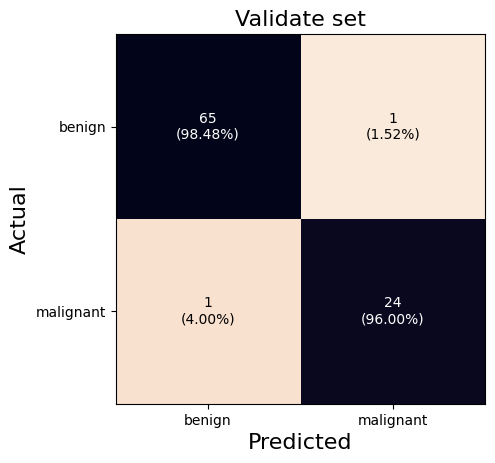

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 97.83%
Accuracy: 96.49%
Precision: 98.48%
Sensitivity: 95.59%
Precision: 98.48%
F1: 97.01%


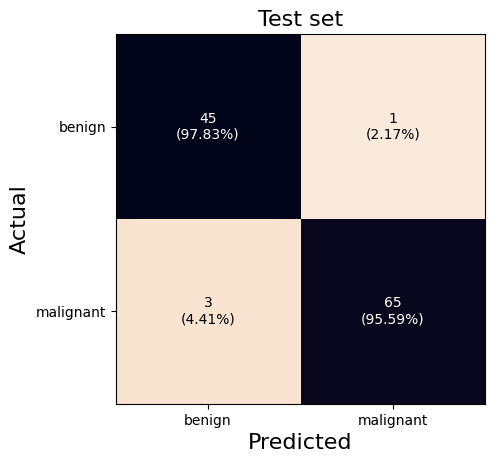

---------------------------------------
AUC validate: 0.9724
AUC test: 0.9671


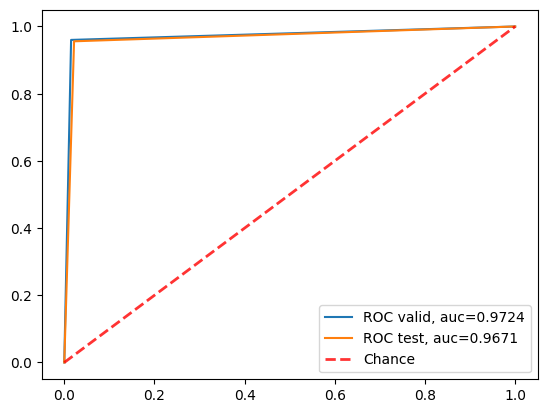

In [522]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split3 = sensitivity(cm_val)
spec_val_split3 = specificity(cm_val)
acc_val_split3 = accuracy(cm_val)
pre_val_split3 = precision(cm_val)
f1_val_split3 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split3 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split3)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split3))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [523]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


split4
############## validate set ################
Confusion Matrix
----------------
[[70  2]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 97.22%
Accuracy: 97.80%
Precision: 90.48%
Sensitivity: 100.00%
Precision: 90.48%
F1: 95.00%


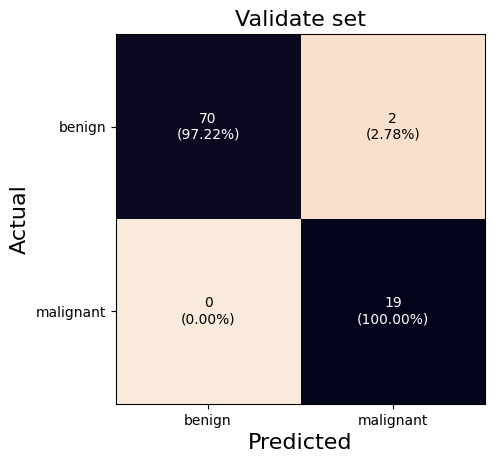

################# test set ##################
Confusion Matrix
----------------
[[43  3]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 93.48%
Accuracy: 93.86%
Precision: 95.52%
Sensitivity: 94.12%
Precision: 95.52%
F1: 94.81%


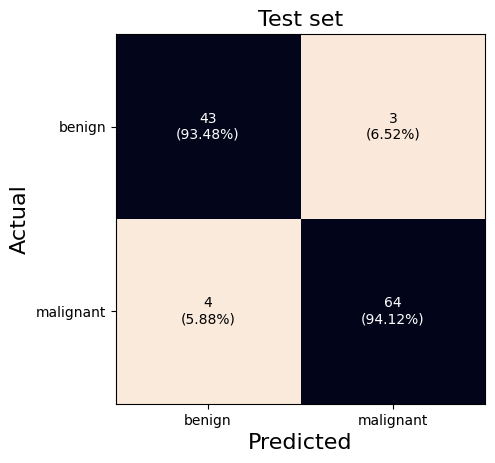

---------------------------------------
AUC validate: 0.9861
AUC test: 0.9380


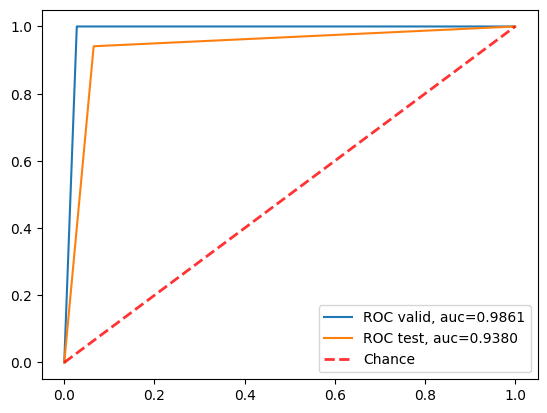

In [524]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split4 = sensitivity(cm_val)
spec_val_split4 = specificity(cm_val)
acc_val_split4 = accuracy(cm_val)
pre_val_split4 = precision(cm_val)
f1_val_split4 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split4 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split4)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split4))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [525]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


split5
############## validate set ################
Confusion Matrix
----------------
[[66  2]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 97.06%
Accuracy: 97.80%
Precision: 92.00%
Sensitivity: 100.00%
Precision: 92.00%
F1: 95.83%


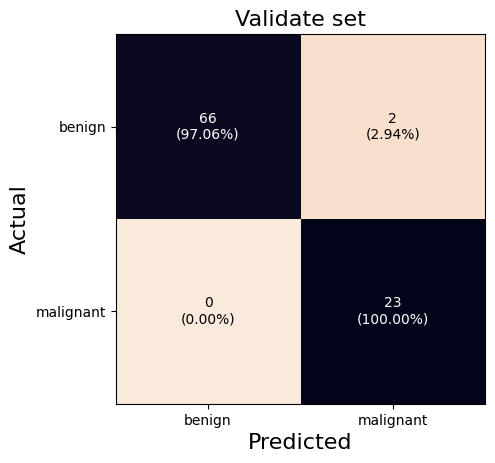

################# test set ##################
Confusion Matrix
----------------
[[42  4]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 91.30%
Accuracy: 93.86%
Precision: 94.20%
Sensitivity: 95.59%
Precision: 94.20%
F1: 94.89%


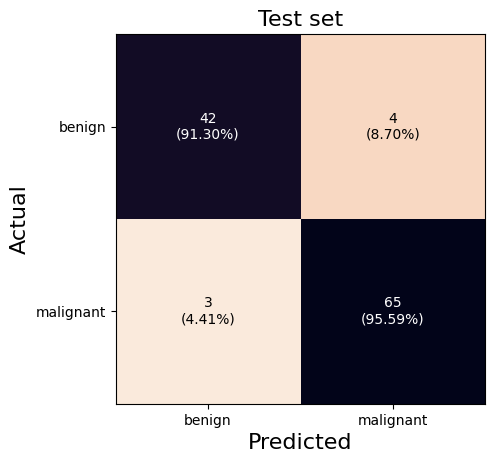

---------------------------------------
AUC validate: 0.9853
AUC test: 0.9345


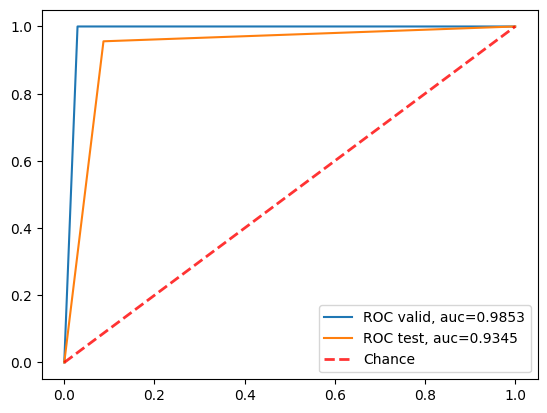

In [526]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split5 = sensitivity(cm_val)
spec_val_split5 = specificity(cm_val)
acc_val_split5 = accuracy(cm_val)
pre_val_split5 = precision(cm_val)
f1_val_split5 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split5 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split5)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split5))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [527]:
val_split1 = np.array([[46, 6], [1, 38]])
val_split2 = np.array([[47, 6], [2, 36]])
val_split3 = np.array([[59, 7], [0, 25]])
val_split4 = np.array([[45, 27], [0, 19]])
val_split5 = np.array([[47, 21], [0, 23]])

In [528]:
overall_val = val_split1 + val_split2 + val_split3 + val_split4 + val_split5
print(overall_val)

[[244  67]
 [  3 141]]


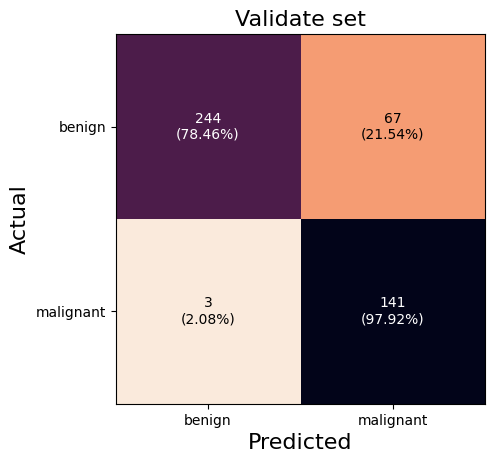

In [529]:
# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = overall_val.astype('float') / overall_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(overall_val[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

In [530]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))

[92.3076923076923, 94.73684210526315, 96.0, 100.0, 100.0]
Mean Sensitivity: 96.60890688259109
Sensitivity Standard Deviation: 3.3680434232420677
Overall Sensitivity: 96.61 ± 3.37%
[98.07692307692307, 94.33962264150944, 98.48484848484848, 97.22222222222221, 97.05882352941177]
Mean Specificity: 97.03648799098299
Specificity Standard Deviation: 1.6192847249918307
Overall Specificity: 97.04 ± 1.62%
[95.6043956043956, 94.5054945054945, 97.8021978021978, 97.8021978021978, 97.8021978021978]
Mean accuracy: 96.7032967032967
accuracy Standard Deviation: 1.5540808377726314
Overall accuracy: 96.70 ± 1.55%
[97.2972972972973, 92.3076923076923, 96.0, 90.47619047619048, 92.0]
Mean precision: 93.61623601623602
precision Standard Deviation: 2.8903691103441513
Overall precision: 93.62 ± 2.89%
[94.73684210526316, 93.50649350649351, 96.0, 95.0, 95.83333333333333]
Mean f1: 95.015333789018
f1 Standard Deviation: 0.9991349436793511
Overall f1: 95.02 ± 1.00%
[0.951923076923077, 0.9453823237338629, 0.9724242424

parameter2 split2

In [531]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


In [532]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [533]:
# create the individual models
model = LogisticRegression(C=0.08685113737513521, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

split2
############## validate set ################
Confusion Matrix
----------------
[[52  1]
 [ 3 35]] 

----------------
Sensitivity: 92.11%
Specificity: 98.11%
Accuracy: 95.60%
Precision: 97.22%
Sensitivity: 92.11%
Precision: 97.22%
F1: 94.59%


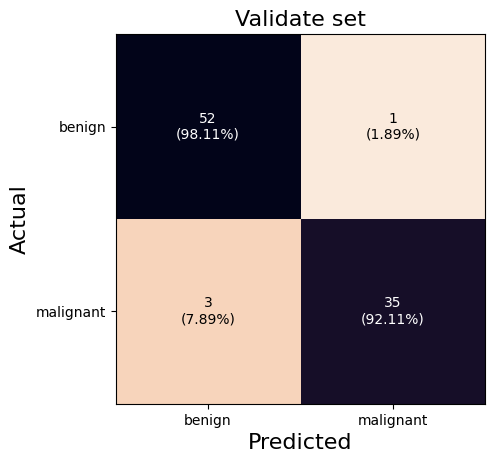

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


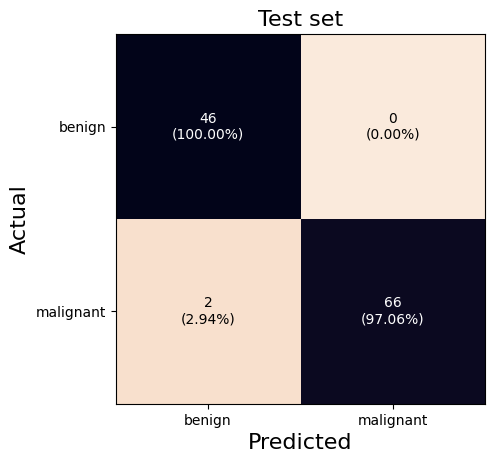

---------------------------------------
AUC validate: 0.9511
AUC test: 0.9853


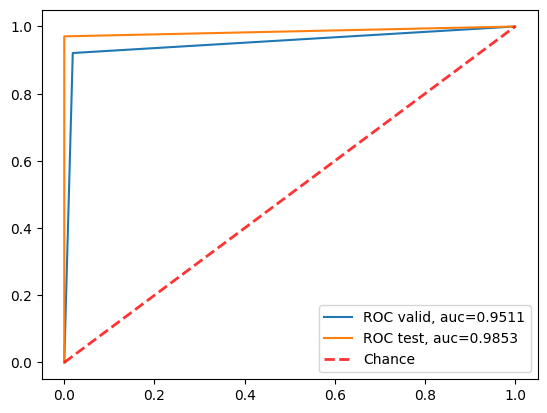

In [534]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split2 = sensitivity(cm_val)
spec_val_split2 = specificity(cm_val)
acc_val_split2 = accuracy(cm_val)
pre_val_split2 = precision(cm_val)
f1_val_split2 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split2 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split2)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split2))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [535]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


split1
############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 2 37]] 

----------------
Sensitivity: 94.87%
Specificity: 98.08%
Accuracy: 96.70%
Precision: 97.37%
Sensitivity: 94.87%
Precision: 97.37%
F1: 96.10%


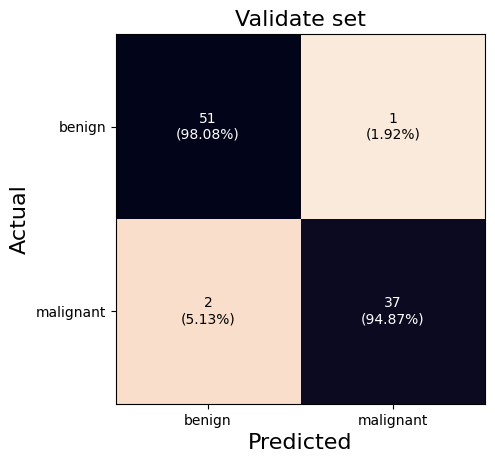

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


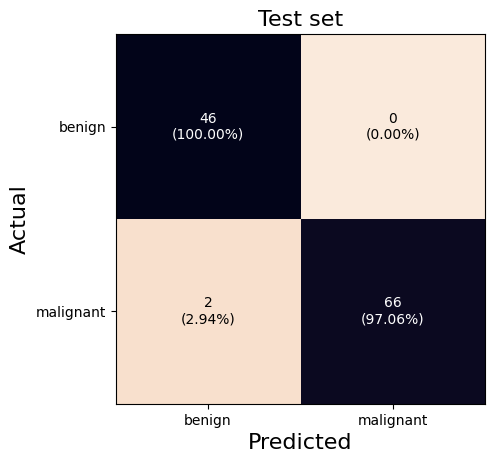

---------------------------------------
AUC validate: 0.9647
AUC test: 0.9853


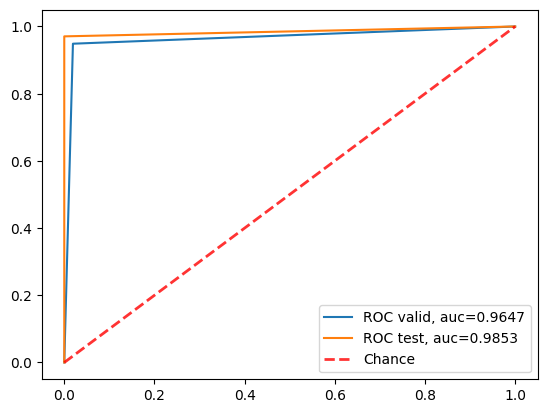

In [536]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split1 = sensitivity(cm_val)
spec_val_split1 = specificity(cm_val)
acc_val_split1 = accuracy(cm_val)
pre_val_split1 = precision(cm_val)
f1_val_split1 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split1 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split1)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [537]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


split3
############## validate set ################
Confusion Matrix
----------------
[[66  0]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 96.00%
Precision: 100.00%
F1: 97.96%


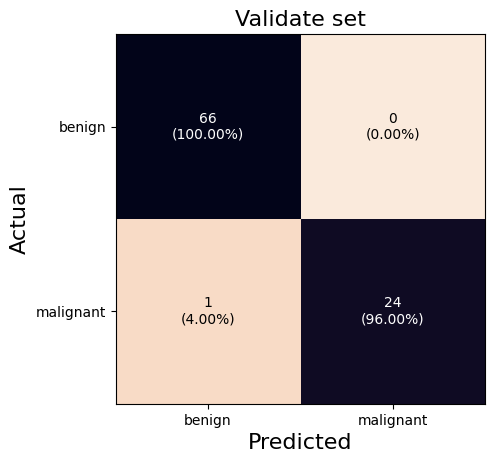

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 97.83%
Accuracy: 96.49%
Precision: 98.48%
Sensitivity: 95.59%
Precision: 98.48%
F1: 97.01%


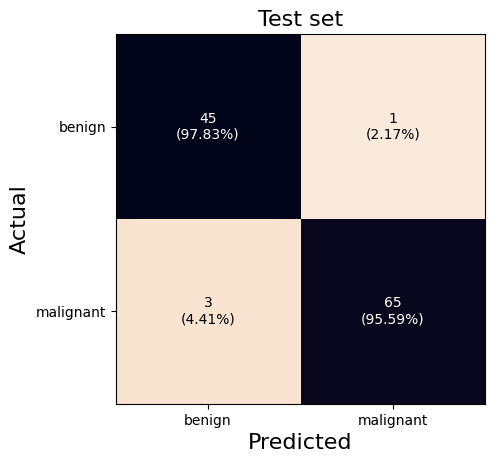

---------------------------------------
AUC validate: 0.9800
AUC test: 0.9671


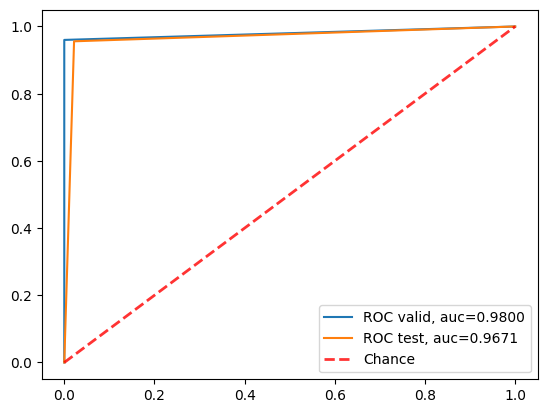

In [538]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split3 = sensitivity(cm_val)
spec_val_split3 = specificity(cm_val)
acc_val_split3 = accuracy(cm_val)
pre_val_split3 = precision(cm_val)
f1_val_split3 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split3 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split3)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split3))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [539]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


split4
############## validate set ################
Confusion Matrix
----------------
[[71  1]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 98.61%
Accuracy: 98.90%
Precision: 95.00%
Sensitivity: 100.00%
Precision: 95.00%
F1: 97.44%


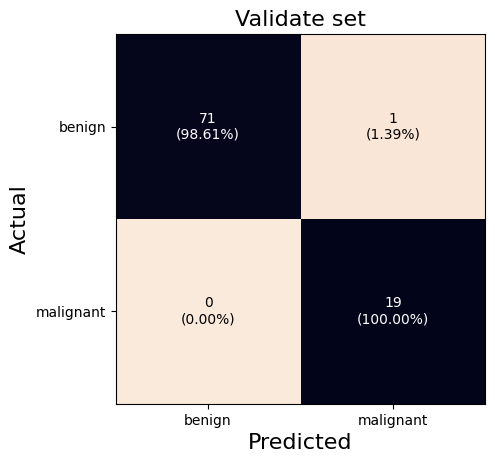

################# test set ##################
Confusion Matrix
----------------
[[44  2]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 95.65%
Accuracy: 96.49%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


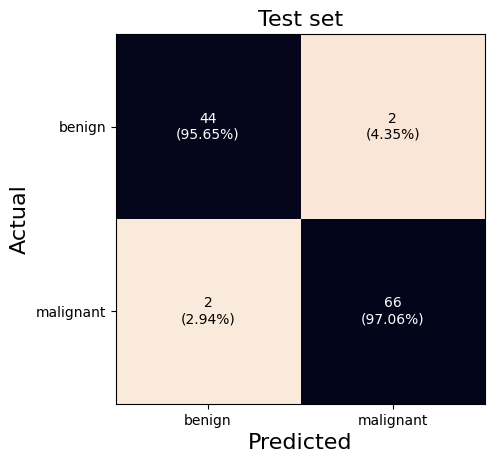

---------------------------------------
AUC validate: 0.9931
AUC test: 0.9636


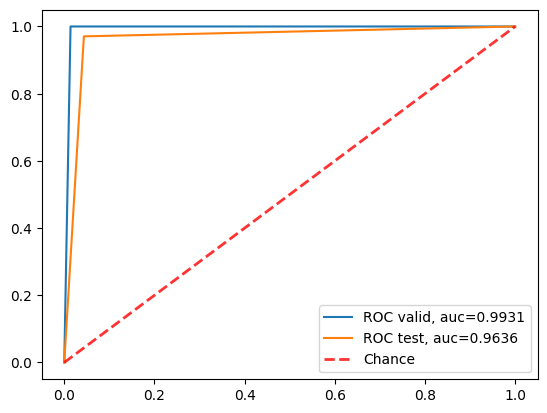

In [540]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split4 = sensitivity(cm_val)
spec_val_split4 = specificity(cm_val)
acc_val_split4 = accuracy(cm_val)
pre_val_split4 = precision(cm_val)
f1_val_split4 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split4 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split4)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split4))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [541]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


split5
############## validate set ################
Confusion Matrix
----------------
[[67  1]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 98.53%
Accuracy: 98.90%
Precision: 95.83%
Sensitivity: 100.00%
Precision: 95.83%
F1: 97.87%


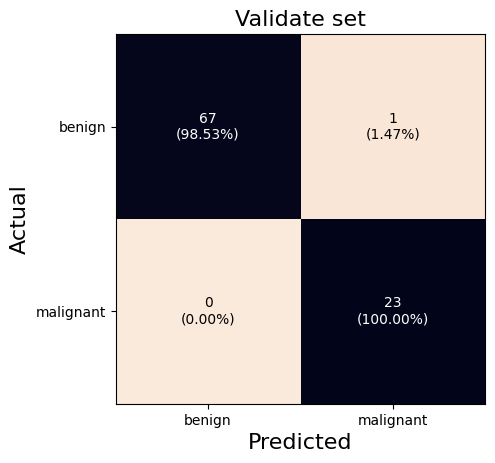

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 97.83%
Accuracy: 96.49%
Precision: 98.48%
Sensitivity: 95.59%
Precision: 98.48%
F1: 97.01%


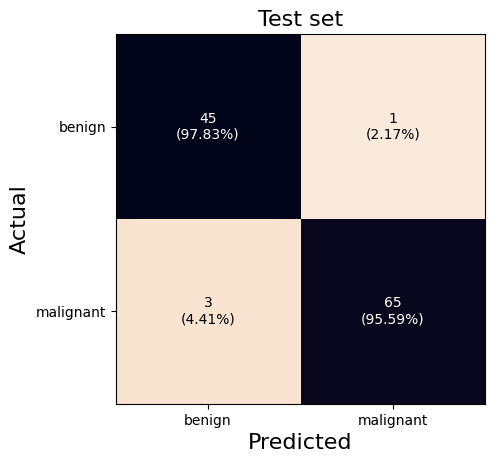

---------------------------------------
AUC validate: 0.9926
AUC test: 0.9671


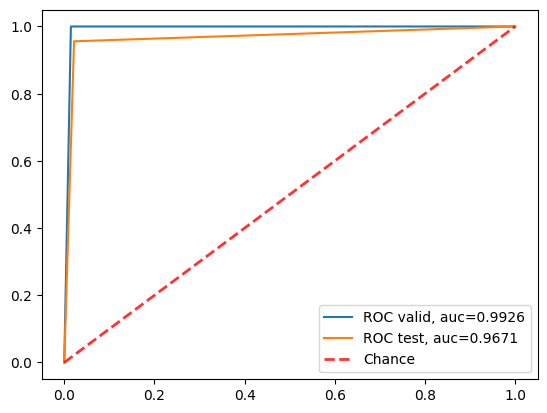

In [542]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split5 = sensitivity(cm_val)
spec_val_split5 = specificity(cm_val)
acc_val_split5 = accuracy(cm_val)
pre_val_split5 = precision(cm_val)
f1_val_split5 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split5 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split5)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split5))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [543]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))

[94.87179487179486, 92.10526315789474, 96.0, 100.0, 100.0]
Mean Sensitivity: 96.59541160593793
Sensitivity Standard Deviation: 3.4157446837451335
Overall Sensitivity: 96.60 ± 3.42%
[98.07692307692307, 98.11320754716981, 100.0, 98.61111111111111, 98.52941176470588]
Mean Specificity: 98.66613069998198
Specificity Standard Deviation: 0.7832330700276259
Overall Specificity: 98.67 ± 0.78%
[96.7032967032967, 95.6043956043956, 98.9010989010989, 98.9010989010989, 98.9010989010989]
Mean accuracy: 97.80219780219781
accuracy Standard Deviation: 1.5540808377726338
Overall accuracy: 97.80 ± 1.55%
[97.36842105263158, 97.22222222222221, 100.0, 95.0, 95.83333333333334]
Mean precision: 97.08479532163743
precision Standard Deviation: 1.904617853161406
Overall precision: 97.08 ± 1.90%
[96.10389610389609, 94.59459459459458, 97.95918367346938, 97.43589743589743, 97.87234042553192]
Mean f1: 96.79318244667787
f1 Standard Deviation: 1.435803570064935
Overall f1: 96.79 ± 1.44%
[0.9647435897435896, 0.9510923535

parameter3 split3

In [544]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


In [545]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [546]:
# create the individual models
model = LogisticRegression(C=24.420530945486497, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

split3
############## validate set ################
Confusion Matrix
----------------
[[65  1]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 98.48%
Accuracy: 97.80%
Precision: 96.00%
Sensitivity: 96.00%
Precision: 96.00%
F1: 96.00%


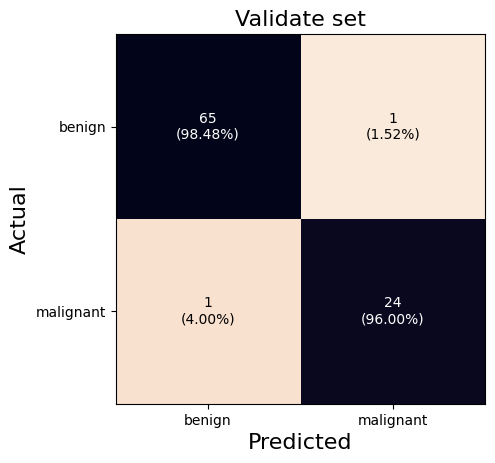

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 97.83%
Accuracy: 96.49%
Precision: 98.48%
Sensitivity: 95.59%
Precision: 98.48%
F1: 97.01%


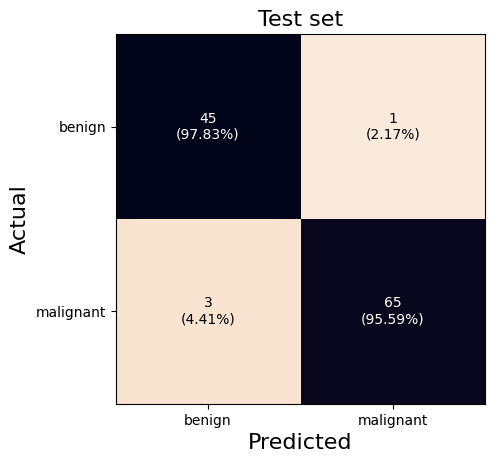

---------------------------------------
AUC validate: 0.9724
AUC test: 0.9671


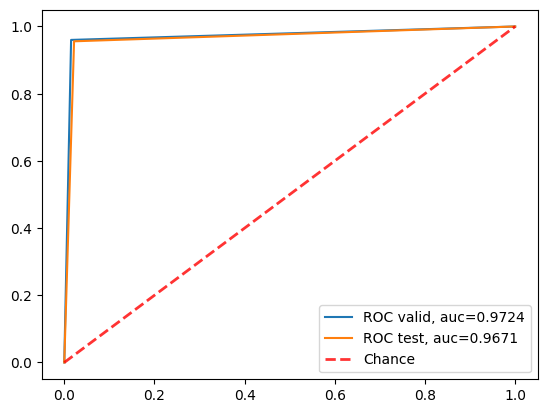

In [547]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split3 = sensitivity(cm_val)
spec_val_split3 = specificity(cm_val)
acc_val_split3 = accuracy(cm_val)
pre_val_split3 = precision(cm_val)
f1_val_split3 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split3 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split3)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split3))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [548]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


split1
############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 3 36]] 

----------------
Sensitivity: 92.31%
Specificity: 98.08%
Accuracy: 95.60%
Precision: 97.30%
Sensitivity: 92.31%
Precision: 97.30%
F1: 94.74%


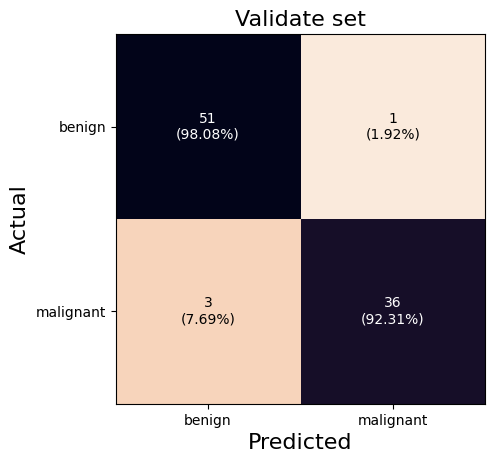

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 97.83%
Accuracy: 95.61%
Precision: 98.46%
Sensitivity: 94.12%
Precision: 98.46%
F1: 96.24%


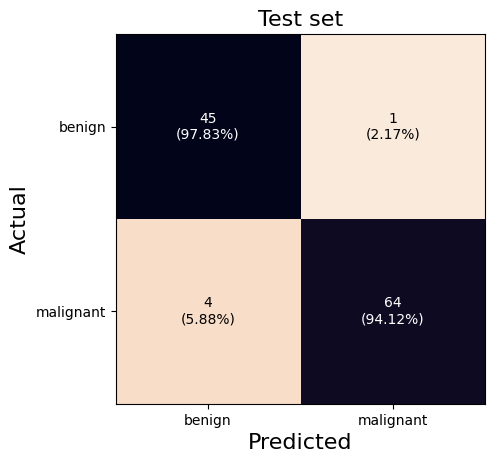

---------------------------------------
AUC validate: 0.9519
AUC test: 0.9597


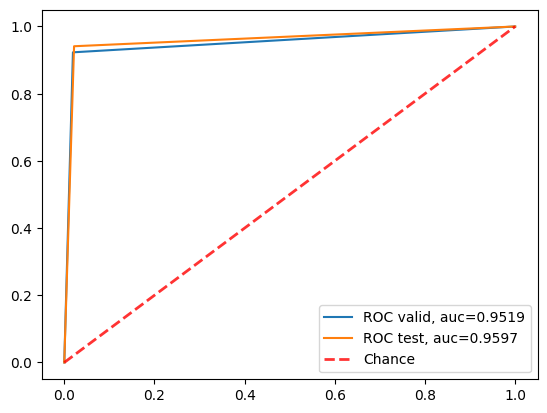

In [549]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split1 = sensitivity(cm_val)
spec_val_split1 = specificity(cm_val)
acc_val_split1 = accuracy(cm_val)
pre_val_split1 = precision(cm_val)
f1_val_split1 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split1 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split1)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [550]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


split2
############## validate set ################
Confusion Matrix
----------------
[[50  3]
 [ 2 36]] 

----------------
Sensitivity: 94.74%
Specificity: 94.34%
Accuracy: 94.51%
Precision: 92.31%
Sensitivity: 94.74%
Precision: 92.31%
F1: 93.51%


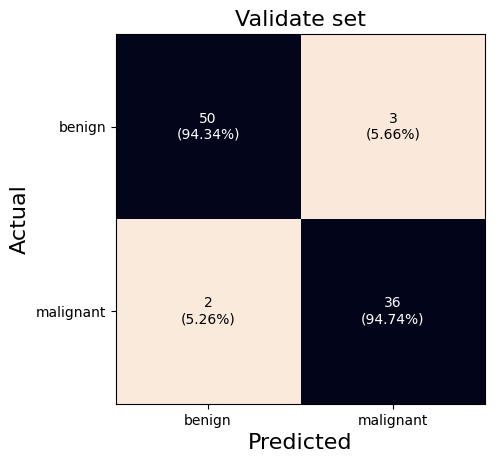

################# test set ##################
Confusion Matrix
----------------
[[43  3]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 93.48%
Accuracy: 94.74%
Precision: 95.59%
Sensitivity: 95.59%
Precision: 95.59%
F1: 95.59%


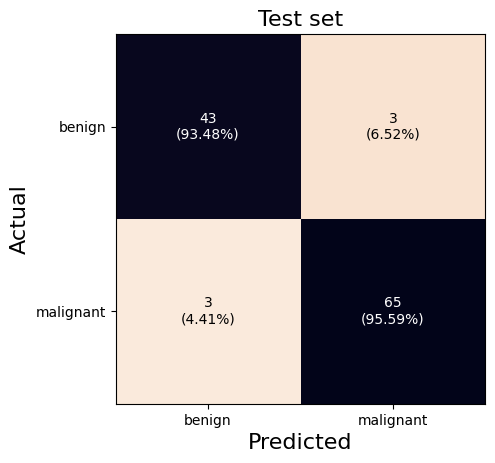

---------------------------------------
AUC validate: 0.9454
AUC test: 0.9453


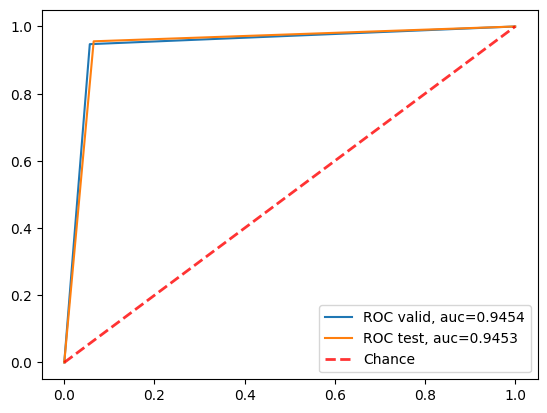

In [551]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split2 = sensitivity(cm_val)
spec_val_split2 = specificity(cm_val)
acc_val_split2 = accuracy(cm_val)
pre_val_split2 = precision(cm_val)
f1_val_split2 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split2 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split2)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split2))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [552]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


split4
############## validate set ################
Confusion Matrix
----------------
[[70  2]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 97.22%
Accuracy: 97.80%
Precision: 90.48%
Sensitivity: 100.00%
Precision: 90.48%
F1: 95.00%


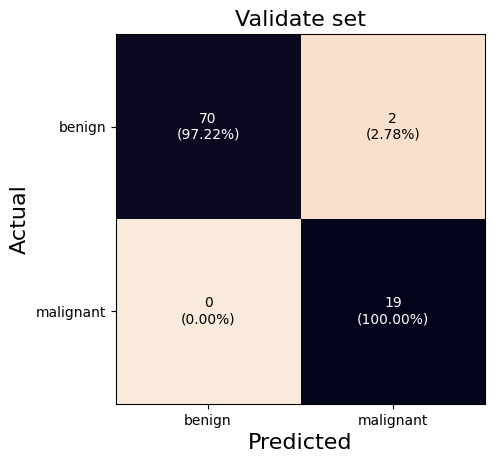

################# test set ##################
Confusion Matrix
----------------
[[43  3]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 93.48%
Accuracy: 94.74%
Precision: 95.59%
Sensitivity: 95.59%
Precision: 95.59%
F1: 95.59%


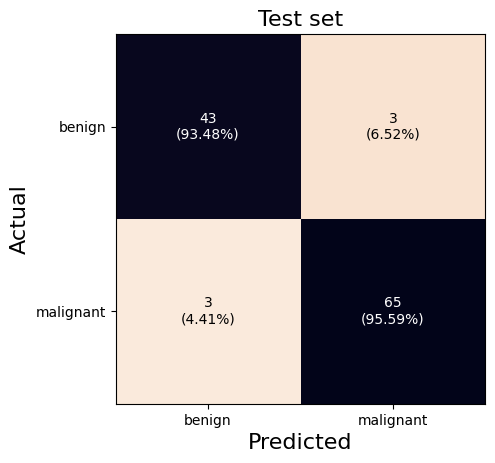

---------------------------------------
AUC validate: 0.9861
AUC test: 0.9453


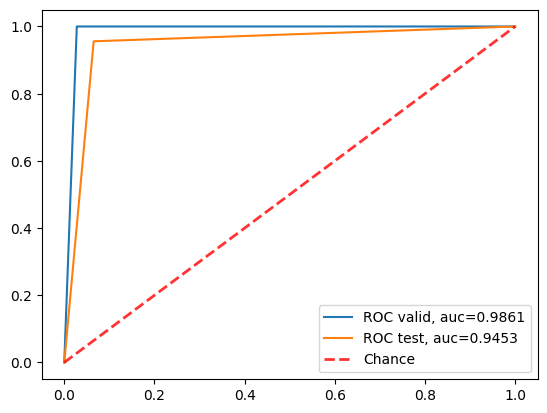

In [553]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split4 = sensitivity(cm_val)
spec_val_split4 = specificity(cm_val)
acc_val_split4 = accuracy(cm_val)
pre_val_split4 = precision(cm_val)
f1_val_split4 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split4 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split4)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split4))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [554]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


split5
############## validate set ################
Confusion Matrix
----------------
[[66  2]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 97.06%
Accuracy: 97.80%
Precision: 92.00%
Sensitivity: 100.00%
Precision: 92.00%
F1: 95.83%


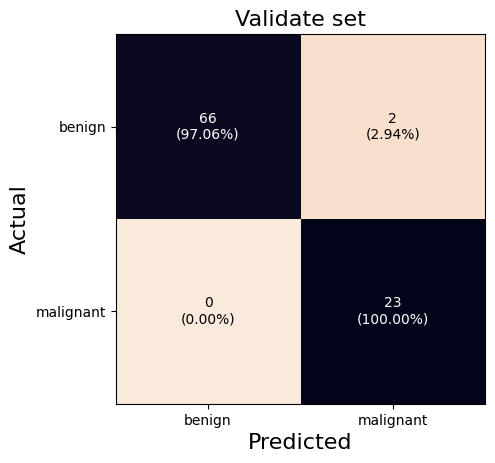

################# test set ##################
Confusion Matrix
----------------
[[42  4]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 91.30%
Accuracy: 93.86%
Precision: 94.20%
Sensitivity: 95.59%
Precision: 94.20%
F1: 94.89%


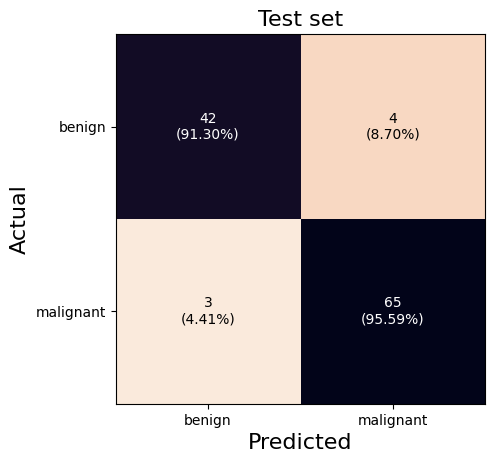

---------------------------------------
AUC validate: 0.9853
AUC test: 0.9345


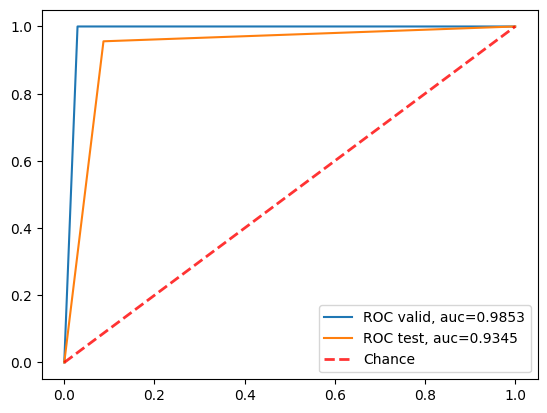

In [555]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split5 = sensitivity(cm_val)
spec_val_split5 = specificity(cm_val)
acc_val_split5 = accuracy(cm_val)
pre_val_split5 = precision(cm_val)
f1_val_split5 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split5 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split5)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split5))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [556]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))

[92.3076923076923, 94.73684210526315, 96.0, 100.0, 100.0]
Mean Sensitivity: 96.60890688259109
Sensitivity Standard Deviation: 3.3680434232420677
Overall Sensitivity: 96.61 ± 3.37%
[98.07692307692307, 94.33962264150944, 98.48484848484848, 97.22222222222221, 97.05882352941177]
Mean Specificity: 97.03648799098299
Specificity Standard Deviation: 1.6192847249918307
Overall Specificity: 97.04 ± 1.62%
[95.6043956043956, 94.5054945054945, 97.8021978021978, 97.8021978021978, 97.8021978021978]
Mean accuracy: 96.7032967032967
accuracy Standard Deviation: 1.5540808377726314
Overall accuracy: 96.70 ± 1.55%
[97.2972972972973, 92.3076923076923, 96.0, 90.47619047619048, 92.0]
Mean precision: 93.61623601623602
precision Standard Deviation: 2.8903691103441513
Overall precision: 93.62 ± 2.89%
[94.73684210526316, 93.50649350649351, 96.0, 95.0, 95.83333333333333]
Mean f1: 95.015333789018
f1 Standard Deviation: 0.9991349436793511
Overall f1: 95.02 ± 1.00%
[0.951923076923077, 0.9453823237338629, 0.9724242424

parameter4 split4

In [557]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


In [558]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [559]:
# create the individual models
model = LogisticRegression(C=0.12648552168552957, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

split4
############## validate set ################
Confusion Matrix
----------------
[[71  1]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 98.61%
Accuracy: 98.90%
Precision: 95.00%
Sensitivity: 100.00%
Precision: 95.00%
F1: 97.44%


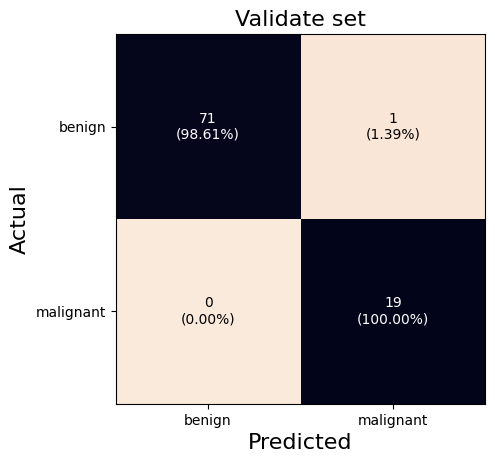

################# test set ##################
Confusion Matrix
----------------
[[44  2]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 95.65%
Accuracy: 96.49%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


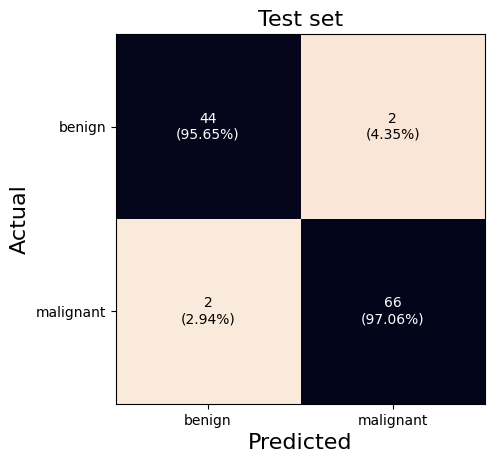

---------------------------------------
AUC validate: 0.9931
AUC test: 0.9636


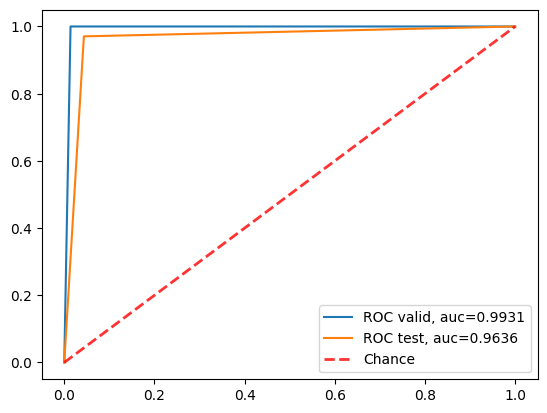

In [560]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split4 = sensitivity(cm_val)
spec_val_split4 = specificity(cm_val)
acc_val_split4 = accuracy(cm_val)
pre_val_split4 = precision(cm_val)
f1_val_split4 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split4 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split4)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split4))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [561]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


split1
############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 2 37]] 

----------------
Sensitivity: 94.87%
Specificity: 98.08%
Accuracy: 96.70%
Precision: 97.37%
Sensitivity: 94.87%
Precision: 97.37%
F1: 96.10%


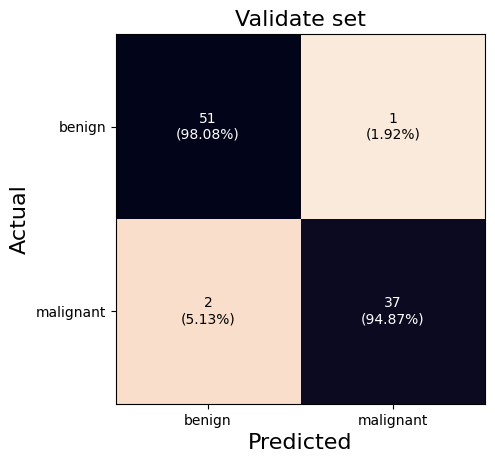

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


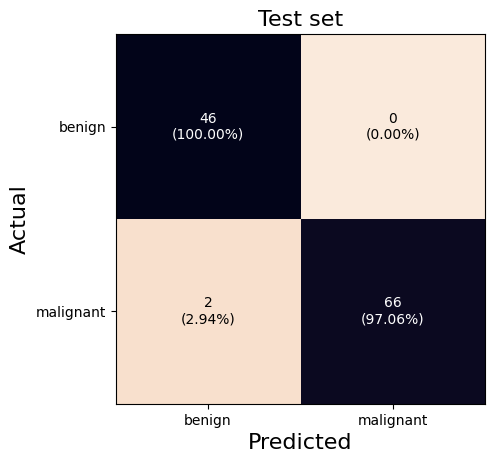

---------------------------------------
AUC validate: 0.9647
AUC test: 0.9853


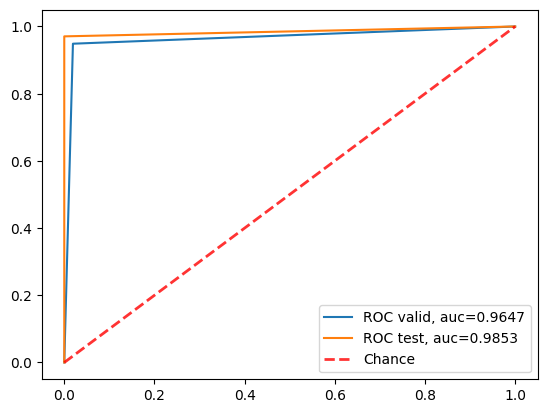

In [562]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split1 = sensitivity(cm_val)
spec_val_split1 = specificity(cm_val)
acc_val_split1 = accuracy(cm_val)
pre_val_split1 = precision(cm_val)
f1_val_split1 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split1 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split1)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [563]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


split2
############## validate set ################
Confusion Matrix
----------------
[[52  1]
 [ 3 35]] 

----------------
Sensitivity: 92.11%
Specificity: 98.11%
Accuracy: 95.60%
Precision: 97.22%
Sensitivity: 92.11%
Precision: 97.22%
F1: 94.59%


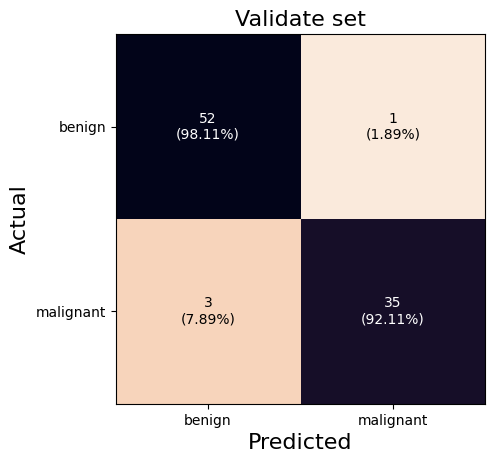

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


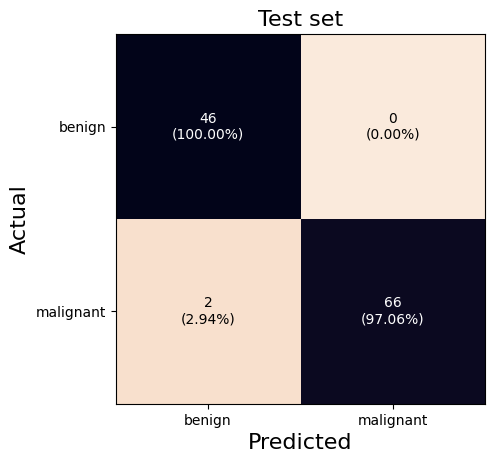

---------------------------------------
AUC validate: 0.9511
AUC test: 0.9853


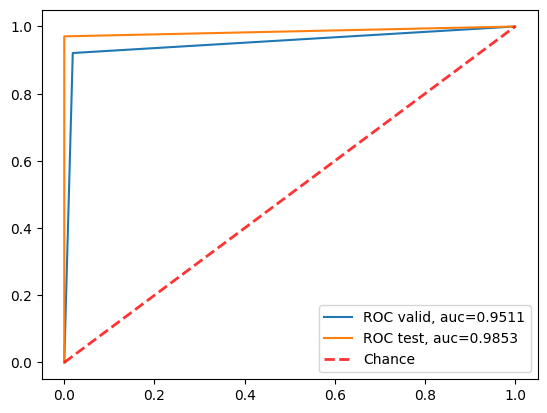

In [564]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split2 = sensitivity(cm_val)
spec_val_split2 = specificity(cm_val)
acc_val_split2 = accuracy(cm_val)
pre_val_split2 = precision(cm_val)
f1_val_split2 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split2 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split2)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split2))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [565]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


split3
############## validate set ################
Confusion Matrix
----------------
[[66  0]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 96.00%
Precision: 100.00%
F1: 97.96%


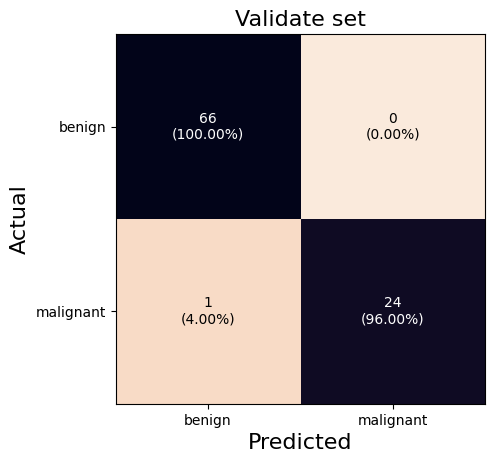

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 97.83%
Accuracy: 96.49%
Precision: 98.48%
Sensitivity: 95.59%
Precision: 98.48%
F1: 97.01%


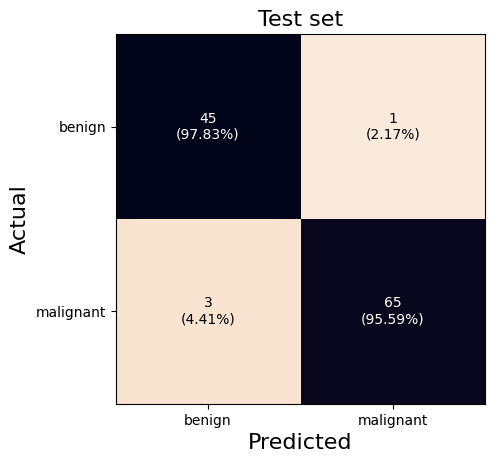

---------------------------------------
AUC validate: 0.9800
AUC test: 0.9671


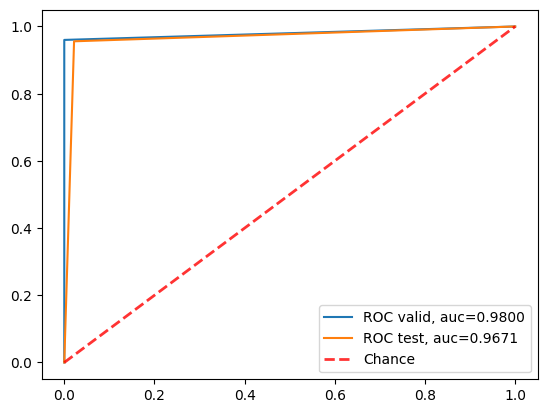

In [566]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split3 = sensitivity(cm_val)
spec_val_split3 = specificity(cm_val)
acc_val_split3 = accuracy(cm_val)
pre_val_split3 = precision(cm_val)
f1_val_split3 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split3 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split3)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split3))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [567]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


split5
############## validate set ################
Confusion Matrix
----------------
[[67  1]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 98.53%
Accuracy: 98.90%
Precision: 95.83%
Sensitivity: 100.00%
Precision: 95.83%
F1: 97.87%


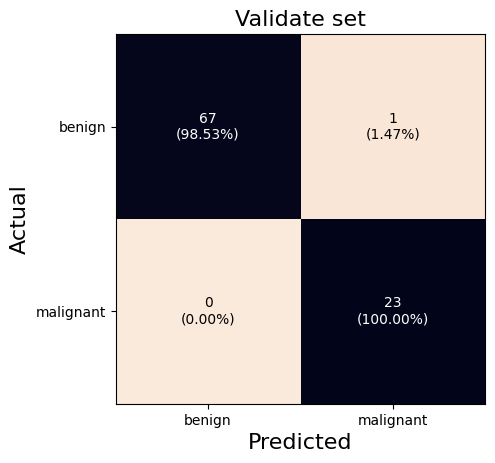

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


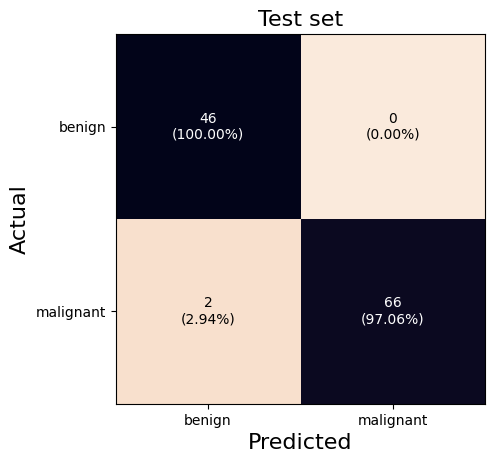

---------------------------------------
AUC validate: 0.9926
AUC test: 0.9853


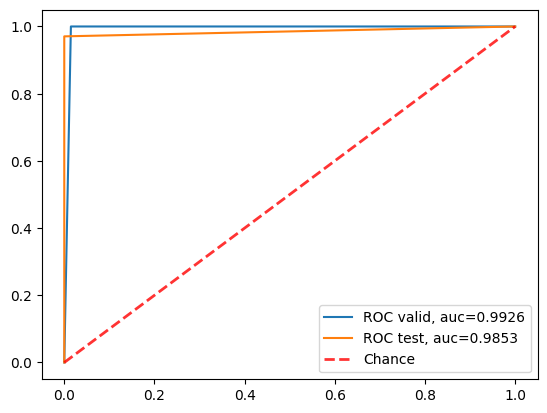

In [568]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split5 = sensitivity(cm_val)
spec_val_split5 = specificity(cm_val)
acc_val_split5 = accuracy(cm_val)
pre_val_split5 = precision(cm_val)
f1_val_split5 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split5 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split5)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split5))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [569]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))

[94.87179487179486, 92.10526315789474, 96.0, 100.0, 100.0]
Mean Sensitivity: 96.59541160593793
Sensitivity Standard Deviation: 3.4157446837451335
Overall Sensitivity: 96.60 ± 3.42%
[98.07692307692307, 98.11320754716981, 100.0, 98.61111111111111, 98.52941176470588]
Mean Specificity: 98.66613069998198
Specificity Standard Deviation: 0.7832330700276259
Overall Specificity: 98.67 ± 0.78%
[96.7032967032967, 95.6043956043956, 98.9010989010989, 98.9010989010989, 98.9010989010989]
Mean accuracy: 97.80219780219781
accuracy Standard Deviation: 1.5540808377726338
Overall accuracy: 97.80 ± 1.55%
[97.36842105263158, 97.22222222222221, 100.0, 95.0, 95.83333333333334]
Mean precision: 97.08479532163743
precision Standard Deviation: 1.904617853161406
Overall precision: 97.08 ± 1.90%
[96.10389610389609, 94.59459459459458, 97.95918367346938, 97.43589743589743, 97.87234042553192]
Mean f1: 96.79318244667787
f1 Standard Deviation: 1.435803570064935
Overall f1: 96.79 ± 1.44%
[0.9647435897435896, 0.9510923535

parameter5 split5

In [570]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


In [571]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [572]:
# create the individual models
model = LogisticRegression(C=339.3221771895323, max_iter=4000, penalty='l2', solver='sag')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

c:\Users\net\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


split5
############## validate set ################
Confusion Matrix
----------------
[[66  2]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 97.06%
Accuracy: 97.80%
Precision: 92.00%
Sensitivity: 100.00%
Precision: 92.00%
F1: 95.83%


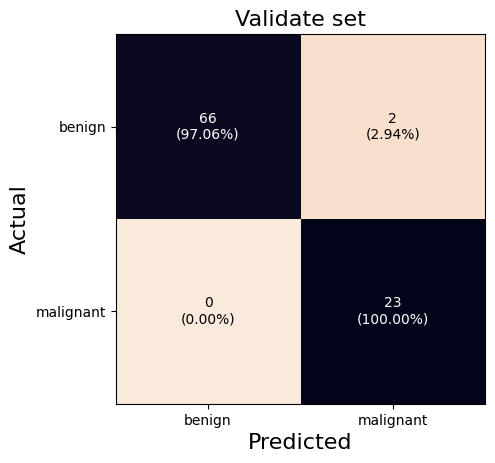

################# test set ##################
Confusion Matrix
----------------
[[42  4]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 91.30%
Accuracy: 93.86%
Precision: 94.20%
Sensitivity: 95.59%
Precision: 94.20%
F1: 94.89%


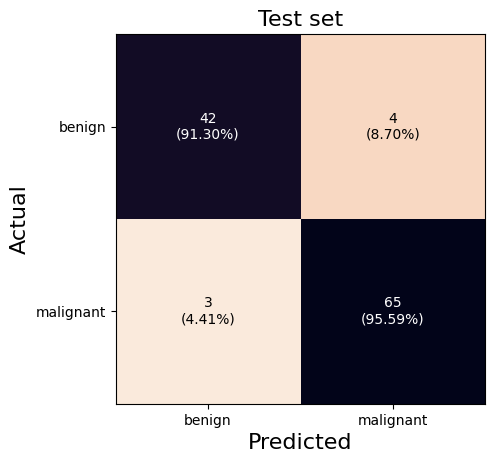

---------------------------------------
AUC validate: 0.9853
AUC test: 0.9345


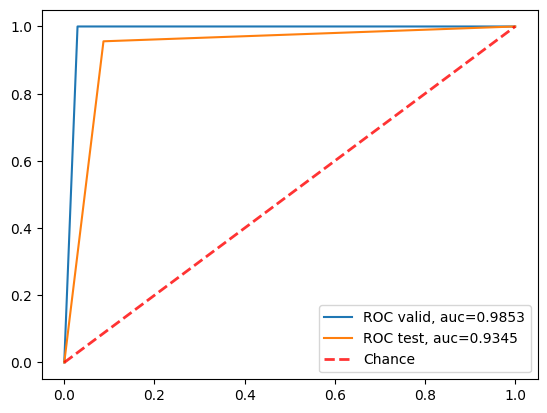

In [573]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [574]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


split1
############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 3 36]] 

----------------
Sensitivity: 92.31%
Specificity: 98.08%
Accuracy: 95.60%
Precision: 97.30%
Sensitivity: 92.31%
Precision: 97.30%
F1: 94.74%


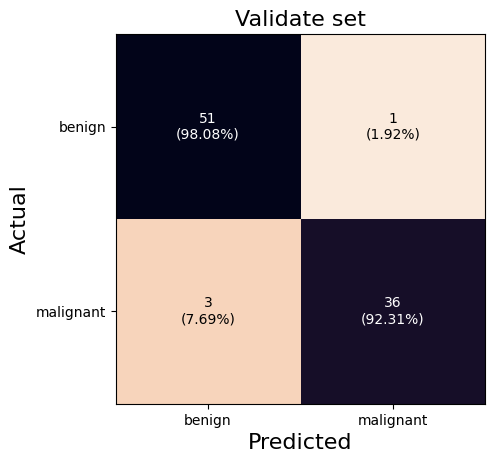

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 5 63]] 

----------------
Sensitivity: 92.65%
Specificity: 97.83%
Accuracy: 94.74%
Precision: 98.44%
Sensitivity: 92.65%
Precision: 98.44%
F1: 95.45%


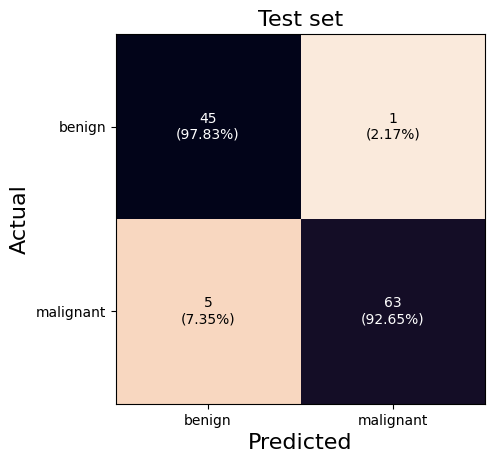

---------------------------------------
AUC validate: 0.9519
AUC test: 0.9524


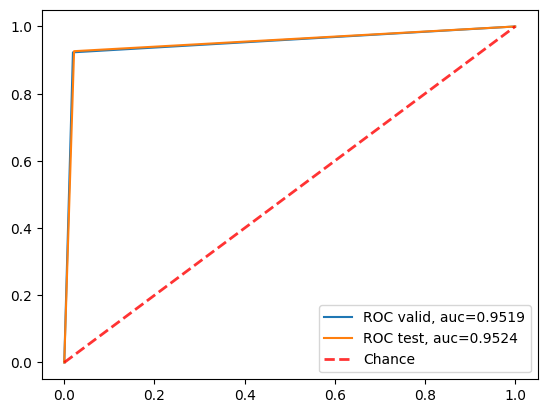

In [575]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [576]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


c:\Users\net\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


split2
############## validate set ################
Confusion Matrix
----------------
[[50  3]
 [ 3 35]] 

----------------
Sensitivity: 92.11%
Specificity: 94.34%
Accuracy: 93.41%
Precision: 92.11%
Sensitivity: 92.11%
Precision: 92.11%
F1: 92.11%


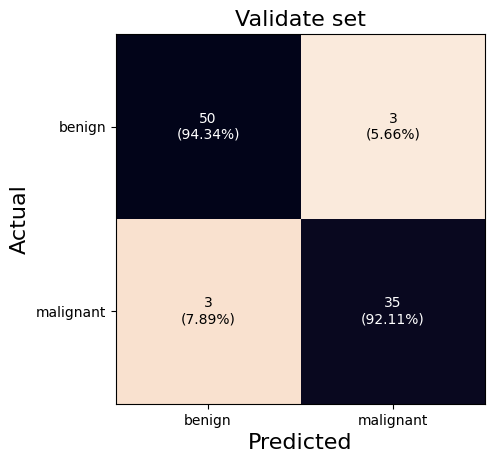

################# test set ##################
Confusion Matrix
----------------
[[43  3]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 93.48%
Accuracy: 94.74%
Precision: 95.59%
Sensitivity: 95.59%
Precision: 95.59%
F1: 95.59%


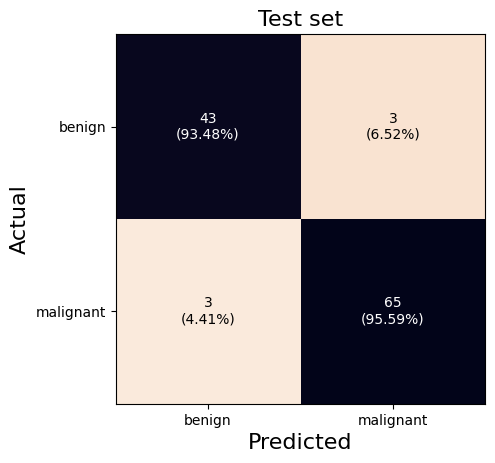

---------------------------------------
AUC validate: 0.9322
AUC test: 0.9453


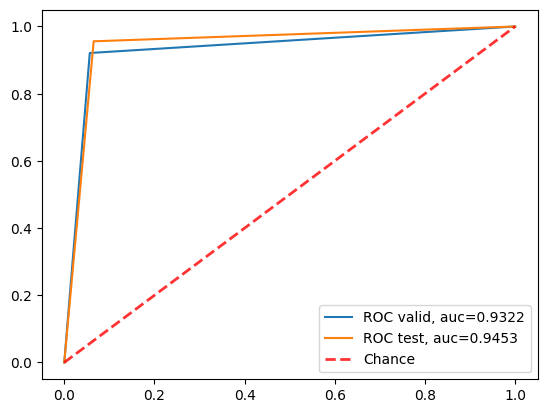

In [577]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [578]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


split3
############## validate set ################
Confusion Matrix
----------------
[[65  1]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 98.48%
Accuracy: 97.80%
Precision: 96.00%
Sensitivity: 96.00%
Precision: 96.00%
F1: 96.00%


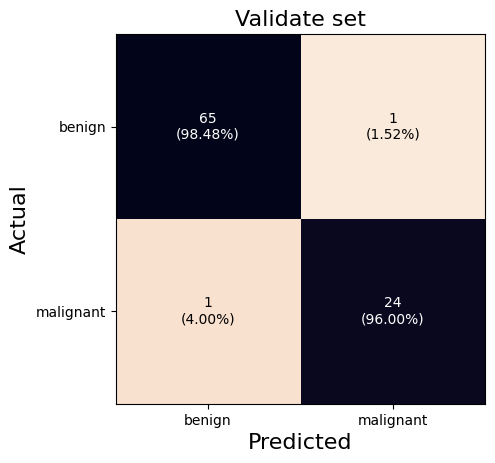

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 97.83%
Accuracy: 96.49%
Precision: 98.48%
Sensitivity: 95.59%
Precision: 98.48%
F1: 97.01%


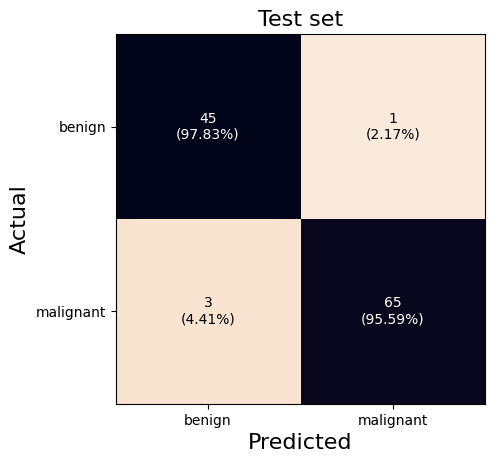

---------------------------------------
AUC validate: 0.9724
AUC test: 0.9671


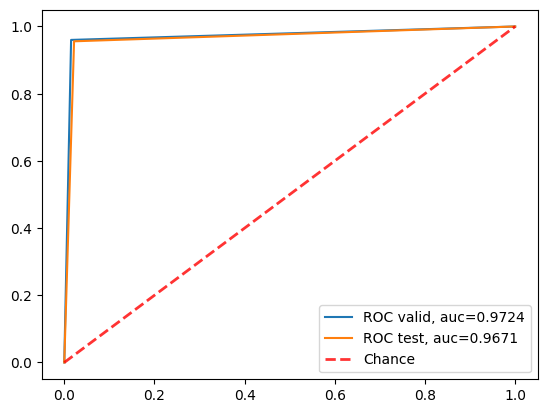

In [579]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [580]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


split4
############## validate set ################
Confusion Matrix
----------------
[[69  3]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 95.83%
Accuracy: 96.70%
Precision: 86.36%
Sensitivity: 100.00%
Precision: 86.36%
F1: 92.68%


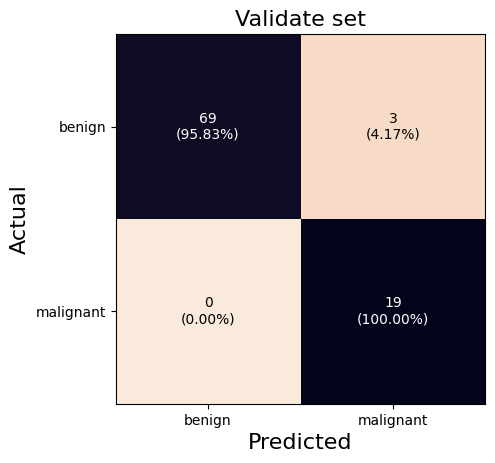

################# test set ##################
Confusion Matrix
----------------
[[43  3]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 93.48%
Accuracy: 93.86%
Precision: 95.52%
Sensitivity: 94.12%
Precision: 95.52%
F1: 94.81%


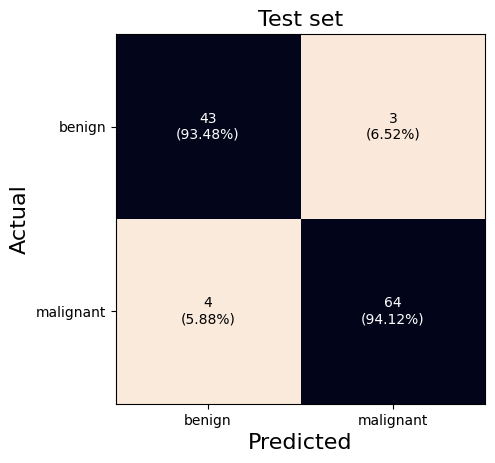

---------------------------------------
AUC validate: 0.9792
AUC test: 0.9380


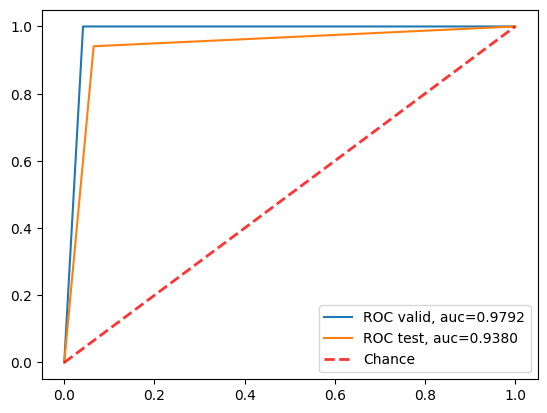

In [581]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [582]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))

[94.87179487179486, 92.10526315789474, 96.0, 100.0, 100.0]
Mean Sensitivity: 96.59541160593793
Sensitivity Standard Deviation: 3.4157446837451335
Overall Sensitivity: 96.60 ± 3.42%
[98.07692307692307, 98.11320754716981, 100.0, 98.61111111111111, 98.52941176470588]
Mean Specificity: 98.66613069998198
Specificity Standard Deviation: 0.7832330700276259
Overall Specificity: 98.67 ± 0.78%
[96.7032967032967, 95.6043956043956, 98.9010989010989, 98.9010989010989, 98.9010989010989]
Mean accuracy: 97.80219780219781
accuracy Standard Deviation: 1.5540808377726338
Overall accuracy: 97.80 ± 1.55%
[97.36842105263158, 97.22222222222221, 100.0, 95.0, 95.83333333333334]
Mean precision: 97.08479532163743
precision Standard Deviation: 1.904617853161406
Overall precision: 97.08 ± 1.90%
[96.10389610389609, 94.59459459459458, 97.95918367346938, 97.43589743589743, 97.87234042553192]
Mean f1: 96.79318244667787
f1 Standard Deviation: 1.435803570064935
Overall f1: 96.79 ± 1.44%
[0.9647435897435896, 0.9510923535